In [0]:
#Mount google drive to use files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Move to git repository file
%cd gdrive/My Drive/Thesis-Colab/thesis


[Errno 2] No such file or directory: 'gdrive/My Drive/Thesis-Colab/thesis'
/content/gdrive/My Drive/Thesis-Colab


In [0]:
# Check if git is updated
!git pull

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [0]:
! ls

 thesis  'Workload Logs'


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Thesis-Colab/thesis')

In [0]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy
import pandas as pd
from parse_logs import parseLog
from analyseLogs import parseLogInfo, extractMultiLog, switch_day
from pathlib import Path
from datetime import datetime
import numpy as np
import scipy.stats as sts
from google.colab import files
from pytz import timezone
from collections import Counter



In [0]:
%cd -

/content


In [0]:
%cd gdrive/My Drive/Thesis-Colab/


/content/gdrive/My Drive/Thesis-Colab


In [0]:
folder = 'Workload Logs'

In [0]:
files = ['Workload Logs/RICC-2010-2.swf',
 'Workload Logs/METACENTRUM-2009-2.swf',
 'Workload Logs/PIK-IPLEX-2009-1.swf',
 'Workload Logs/HPC2N-2002-2.2-cln.swf']

In [0]:
files = ['Workload Logs/RICC-2010-2.swf',
 'Workload Logs/HPC2N-2002-2.2-cln.swf']

In [0]:
def pickUtil(x):
  if x == 0:
    # Low Util

    files = ['Workload Logs/DAS2-fs0-2003-1.swf',
    'Workload Logs/PIK-IPLEX-2009-1.swf',
    'Workload Logs/LPC-EGEE-2004-1.2-cln.swf']

  if x == 1:

    # Med Util 

    files = ['Workload Logs/UniLu-Gaia-2014-2.swf',
    'Workload Logs/Sandia-Ross-2001-1.1-cln.swf',
    'Workload Logs/KIT-FH2-2016-1.swf']

  if x == 2:

    #High Util

    files = ['Workload Logs/SHARCNET-Whale-2005-2.swf',
    'Workload Logs/RICC-2010-2.swf',
    'Workload Logs/HPC2N-2002-2.2-cln.swf']

  return files

#files = pickUtil(0)

In [0]:
def pickCPU(x):

  if x == 0:
# Low CPU
#'Workload Logs/DAS2-fs0-2003-1.swf',
    files = [
    'Workload Logs/CTC-SP2-1995-2.swf',
    'Workload Logs/HPC2N-2002-2.2-cln.swf']

  if x == 1:

 # Med CPU 

    files = ['Workload Logs/LANL-CM5-1994-4.1-cln.swf',
    'Workload Logs/Sandia-Ross-2001-1.1-cln.swf',
    'Workload Logs/UniLu-Gaia-2014-2.swf']

  if x == 2:

    #High CPU

    files = ['Workload Logs/SHARCNET-Whale-2005-2.swf',
    'Workload Logs/PIK-IPLEX-2009-1.swf',
    'Workload Logs/LANL-O2K-1999-2.swf']

  return files

#files = pickCPU(0)

In [0]:
allLogs = []
for x in files:
  allLogs.append(parseLog([x]))


In [0]:
from dateutil import parser
startTime = parseLogInfo(files, "UnixStartTime:")
timeZone = parseLogInfo(files, "TimeZoneString:")
endTime = parseLogInfo(files, "EndTime:")
endTime = [(' '.join(x)) for x in endTime]
endTime = [parser.parse(endTime[x]) for x in range(len(endTime))]
diff = [(endTime[x] - datetime.fromtimestamp(int(startTime[x][0]))).days for x in range(len(endTime))]

/usr/local/lib/python3.6/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname JST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/usr/local/lib/python3.6/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname CET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [0]:
def extractArrivalTime(log, variable):
    arrivalTime = []
    logIndex = 0

    for x in log:
        store = []
        for y in x:
            for z in y:
                time = int(z[1]) + int(startTime[logIndex][0])
                spec = datetime.fromtimestamp(time, tz=timezone(timeZone[logIndex][0]))
                if variable == 1:
                    store.append(spec.hour)
                else:
                    store.append(switch_day(spec.strftime("%A")))
        logIndex += 1
        arrivalTime.append(store)
    return arrivalTime

In [0]:
def extractMonth(log, variable, month):
    extracted = []
    logIndex = 0
    for x in log:
        store = []
        for y in x:
            for z in y:
                time = int(z[1]) + int(startTime[logIndex][0])
                spec = datetime.fromtimestamp(time, tz=timezone(timeZone[logIndex][0]))
                if spec.month == month:
                    store.append(z[variable])
        logIndex += 1
        extracted.append(store)
    return extracted

In [0]:
def extractBOT(log, variable):
    bot = []
    jobCount = []

    for x in log:
        storeSize = 0
        store = []
        for y in x:
            oldTime = 0
            botCount = 0
            for z in y:
                if len(z) != 0:
                    time = int(z[variable])
                    storeSize += 1

                    if oldTime == time:
                        botCount += 1
                    else:
                        if botCount > 0:
                            store.append(botCount)
                            botCount = 0
                        oldTime = time
        bot.append(store)
        jobCount.append(storeSize)
    return bot

In [0]:
def extractInterTime(log, variable):
    extractedLog = []
    jobCount = []

    for x in log:
        store = []
        logIndex = 0
        for y in x:
            oldTime = 0
            for z in y:
                if len(z) != 0:
                    time = int(z[variable])
                    spec = datetime.fromtimestamp(time, tz=timezone(timeZone[logIndex][0]))
                    if oldTime != time:
                        store.append(time - oldTime)
                        oldCalc = time - oldTime
                        oldTime = time
        extractedLog.append(store)
        logIndex +=1
    return extractedLog

In [0]:
# This function will extract the interarrival time, and place into hourly intervals
# For example

def extractHourlyInterTime(log, variable):
    extractedLog = []
    jobCount = []

    for x in log:
        store = [[] for x in range(24)]
        logIndex = 0
        for y in x:
            oldTime = 0
            for z in y:
                if len(z) != 0:
                    time = int(z[variable])
                    spec = datetime.fromtimestamp(time, tz=timezone(timeZone[logIndex][0]))
                    if oldTime != time:
                        store[spec.hour].append(time - oldTime)
                        oldCalc = time - oldTime
                        oldTime = time
        extractedLog.append(store)
        logIndex +=1
    return extractedLog

In [0]:
def extractReqRuntime(log):
  extracted = []
  logIndex = 0
  for x in log:
    store = []
    for y in x:
      for z in y:
        calc = round(((int(z[3]) - int(z[8]))/int(z[8]))*100)
        store.append(calc)
    logIndex += 1
    extracted.append(store)
  return extracted

In [0]:
def is_power_of_two(n):
    if n == 1:
        return False
    return (n != 0) and (n & (n-1) == 0)

In [0]:
name = ['RICC','METACENTRUM','PIK-IPLEX','HPC2N']

In [0]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [0]:
jobArrival = extractArrivalTime(allLogs, 1)
jobRuntime = extractMultiLog(allLogs, 8)

In [0]:
# Getting points for arrival rate

index = 3
cnt = Counter(jobArrival[index])
pts = {k: v//diff[index] for k,v in cnt.items()}
pts = [k for k,v in pts.items() for x in range(v)]
print(np.size(pts))
pts = np.array(pts)


147


In [0]:
# Getting points for runtime

index = 1
cnt = Counter(jobRunTime[index])
print(cnt)
cnt50 = {k:v for k,v in cnt.items() if k < 50000}
cnt50d = [k for k,v in cnt50.items() for x in range(v)]
pts = np.array(cnt50d)


NameError: ignored

In [0]:
# Getting points for requested runtime

index = 1
reqRuntime = extractReqRuntime(allLogs)
cnt = Counter(reqRuntime[index])
print(cnt)

# pts = np.array(cnt50d)

Counter({-100: 32724, 0: 9841, -99: 8512, -1: 6815, -2: 6390, -3: 6152, -98: 5768, -97: 4768, -8: 3867, -7: 3556, -30: 3383, -96: 2879, -31: 2474, -95: 2436, -9: 2421, -21: 2382, -20: 2265, -90: 2125, -94: 2106, -93: 2098, -29: 2056, -32: 1972, -80: 1968, -92: 1834, -16: 1743, -36: 1733, -4: 1582, -35: 1553, -91: 1491, -37: 1463, -22: 1444, 1: 1422, -88: 1416, -28: 1379, -89: 1341, 2: 1268, -33: 1212, -54: 1209, -34: 1191, -17: 1190, -52: 1148, -78: 1144, -83: 1140, -87: 1138, -39: 1125, -85: 1111, -15: 1105, -86: 1101, -42: 1084, -18: 1066, -79: 1058, -82: 1056, -76: 1051, -70: 1048, -66: 1020, -84: 1019, -24: 1013, -19: 1003, -10: 1000, -14: 961, -53: 958, -77: 948, -23: 937, -43: 916, -38: 913, -71: 901, -13: 900, -5: 883, -49: 883, -57: 873, -58: 871, -6: 860, -62: 842, -73: 833, -75: 804, -40: 797, -67: 793, -74: 790, -56: 788, -69: 782, -72: 780, -41: 777, -12: 762, -11: 741, -45: 740, -50: 739, -59: 733, -60: 730, -81: 724, -27: 710, -48: 708, -65: 702, -44: 699, -25: 673, -63: 

In [0]:
# Getting points for BOT
index = 3
jobBOT = extractBOT(allLogs, 1)
print(Counter(jobBOT[index]))
reduce = [x for x in jobBOT[index] if x < 21]
pts = np.array(reduce)

Counter({1: 7055, 2: 2303, 3: 1793, 4: 581, 5: 350, 6: 263, 9: 152, 7: 149, 8: 115, 10: 64, 11: 62, 13: 45, 12: 44, 14: 33, 15: 18, 16: 6, 19: 6, 17: 6, 18: 4, 20: 2, 22: 2, 26: 1, 24: 1, 21: 1})


In [0]:
# Getting points for Inter-arrival Time
index = 3
jobInter = extractInterTime(allLogs, 1)
reduce = [x for x in jobInter[index] if x < 10000]
pts = np.array(reduce)


In [0]:
#Inter-arrival Time hourly
index = 0
jobInter = extractHourlyInterTime(allLogs[0], 1)
print(jobInter)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
# Gettings points for Job Size (power of two)
import math

index =3
jobSize = extractMultiLog(allLogs, 4)
#transformLog = [(math.log(x)/math.log(2)) for x in jobSize[index] if x > 1]
transformLog = [x for x in jobSize[index] if is_power_of_two(x)== False and x != 1]
cnt = Counter(transformLog)
#cnt = {int(k):v for k,v in cnt.items() if k % 1 == 0.0}
#cnt = {int(k):v for k,v in cnt.items() if k < 200}
print(cnt)
pts = transformLog#[k for k,v in cnt.items() for x in range(v)]


Counter({6: 3395, 10: 2464, 36: 1924, 12: 1868, 24: 1613, 20: 1531, 18: 727, 40: 408, 9: 301, 25: 251, 50: 219, 3: 155, 30: 154, 28: 148, 5: 141, 14: 139, 7: 137, 48: 131, 72: 120, 60: 115, 98: 86, 49: 55, 100: 43, 22: 39, 26: 38, 42: 36, 120: 22, 84: 22, 96: 15, 80: 13, 54: 12, 11: 10, 62: 9, 15: 6, 81: 4, 23: 4, 13: 4, 58: 4, 44: 4, 140: 3, 56: 3, 52: 1, 190: 1, 200: 1, 70: 1, 90: 1, 38: 1, 110: 1, 31: 1})


In [0]:
# Getting points for Job Memory 
index = 0
variable = 9
#if index == 0:
#  variable = 9
jobMem = extractMultiLog(allLogs, variable)
cnt = [round(x/1000) for x in jobMem[index] if x > 0]
cnt = Counter(cnt)
pts = [k for k,v in cnt.items() for x in range(v)]
print(cnt)
pts = np.array(pts)
print(pts)

Counter({131: 64690, 262: 5492, 524: 3965, 1049: 419, 2097: 218, 16: 186, 33: 174, 2048: 166, 1024: 142, 1: 118, 66: 80, 205: 67, 1023: 34, 2: 31, 1573: 29, 614: 28, 102: 21, 1843: 17, 819: 13, 573: 12, 171: 11, 676: 9, 307: 7, 1536: 4, 717: 3, 283: 2, 348: 2, 1434: 2, 983: 1, 129: 1})
[ 131  131  131 ... 1843 1843  129]


kstwobign (-1684.9569280427413, 2508.474655750943)
0.007820512824148305

kstwobign 0.005997470449280156
['kstwobign']


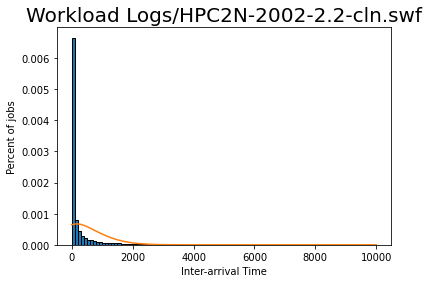

In [0]:
num_bins = 100
size = max(pts)

# density=True,
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title(files[index], fontsize=20)
plt.xlabel(r'Inter-arrival Time')
plt.ylabel(r'Percent of jobs')
#dist_names = [ 'expon', 'exponweib', 'gamma', 'gengamma','invgamma','invweibull','logistic', 'loggamma', 'lognorm', 'lomax', 'maxwell', 'norm', 'powerlognorm', 'powernorm']
dist_names = ['alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min', 'weibull_max', 'wrapcauchy']
dist_names = ['kstwobign']
sseDict = {}
best_dist = ''
best_sse = 1
for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(pts)
    print(dist_name, param)
    rX = np.linspace(0,size,num_bins)
    rP = dist.pdf(rX, *param)
    count = 0
    for x in rP:
      count += x

    print(count)
    sse = np.sum(np.power(count - rP, 2.0))
    sseDict[dist_name] = sse
    plt.plot(rX, rP, label=dist_name)

print()
sseDict = {key:value for key, value in sorted(sseDict.items(), key=lambda item: item[1])}
size = 0
best = []

for key,value in sseDict.items():
  if size < 20:
    print(key, value)
    best.append(key)
  size += 1

print(best)

In [0]:

'''print(best_sse, best_dist)
plt.figure()
plt.title('RICC ', fontsize=20)
plt.xlabel(r'Arrival Rate Hourly')
plt.ylabel(r'Percent of jobs')
dist = getattr(scipy.stats, best_dist)
param = dist.fit(pts)
rX = np.linspace(0,24,24)
rP = dist.pdf(rX, *param)
sse = np.sum(np.power(count - rP, 2.0))
plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.plot(rX, rP, label=dist_name)
'''